In [1]:
import sys
sys.version

'2.7.13 |Anaconda 2.4.1 (64-bit)| (default, Dec 19 2016, 13:46:45) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [2]:
import numpy as np
import random
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline  

from timeit import default_timer as timer

In [3]:
def generate_mixture(n_points):
    ''' Generate a dataset with 2D n_points as a mixture'''
    X = np.concatenate([np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], n_points),
                        np.random.multivariate_normal([8,6], [[2, 0], [0, 2]], n_points), 
                        np.random.multivariate_normal([4,2], [[1, 0.2], [0.2, 0.5]], n_points)])
    return(X)

In [4]:
X = generate_mixture(50)

centers1 = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), 1)])
centers2 = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), 1)])
centers3 = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), 1)])

# Numpy

In [5]:
def kmeans(X, k, max_iter=100, epsilon = 0.01):
    # Initialize from random points.
    centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)])
    cluster = [None] * np.shape(X)[0]
    old_centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]) #beware !
    ''' Beware : a better initialization ?'''
    
    n_iter = 1
 
    while (n_iter <= max_iter) & (np.linalg.norm(centers - old_centers) > epsilon):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: np.linalg.norm(np.array(x) - np.array(centers[j])))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            old_centers = centers.copy()
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
            
        n_iter += 1    
    return cluster, np.array(centers), n_iter


## Test with Numpy

In [6]:
n_points = 200
n_clusters = 3
max_iter = 20

X = generate_mixture(n_points)

Kmeans with 200 points and 3 clusters with 6 iterations on CPU in 0.057027 s


(-5, 15)

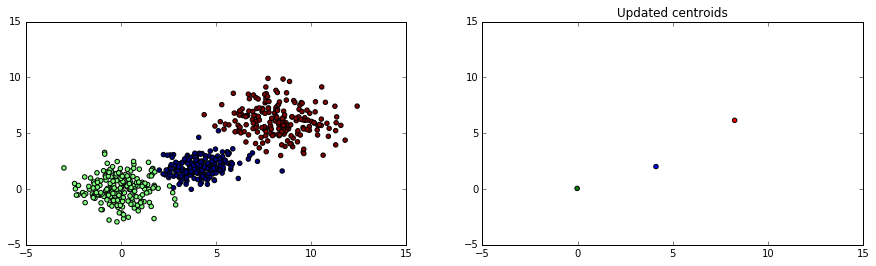

In [7]:
start = timer()
cluster, centers, n_iter = kmeans(X, n_clusters, max_iter, 0.1)
dt = timer() - start
print("Kmeans with %.0f points and %.0f clusters with %.0f iterations on CPU in %f s" % (n_points, n_clusters, n_iter-1, dt))

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c = cluster)
plt.xlim([-5, 15])
plt.ylim([-5, 15])

plt.subplot(1, 2, 2)
plt.title('Updated centroids')
plt.scatter(centers[:, 0], centers[:, 1], c = 'bgr')
plt.xlim([-5, 15])
plt.ylim([-5, 15])


# Theano

In [8]:
def kmeans_theano(X, k, max_iter=100):
    # Initialize from random points.
    centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)])
    cluster = [None] * np.shape(X)[0]
    old_centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]) #beware !
    ''' Beware : a better initialization ?'''
    
    n_iter = 1
 
    while (n_iter <= max_iter) & (np.linalg.norm(centers - old_centers) > epsilon):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: np.linalg.norm(np.array(x) - np.array(centers[j])))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            old_centers = centers.copy()
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
            
        n_iter += 1    
    return cluster, np.array(centers), n_iter


In [9]:
import theano
from theano import tensor as T
import numpy as np

def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def model(X,w):
    return T.nnet.softmax(T.dot(X,w))

X = T.fmatrix()
Y = T.fmatrix()

w = init_weights((784, 10))

py_x = model(X,w)
y_pred = T.argmax(py_x, axis = 1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
gradient = T.grad(cost = cost, wrt = w)
update = [[w, w - 0.05 * gradient]]

train = theano.function(inputs = [X,Y], outputs = cost, 
                        updates = update)

predict = theano.function(inputs=[X], outputs = y_pred)



Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


In [10]:
import theano
from theano import tensor as T

# Generate some data
X = generate_mixture(n_points)

# Initialize the centroids
def init_centroids(X, n_clusters):
    return theano.shared(floatX(np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), n_clusters)])))

centroids = init_centroids(X, n_clusters)

# Initialize the clusters
def get_clusters(X, centroids):
    distance_point_centroids = theano.shared(floatX())

print(centroids.get_value())
cost = T.mean(T.square(X-centroids))





[[ 4.9692111   2.85370612]
 [ 5.14301157  1.60165811]
 [ 4.97204065  2.72525859]]


In [11]:
centroids.get_value()[0,:]

array([ 4.9692111 ,  2.85370612], dtype=float32)

In [12]:
ccc = floatX(np.linalg.norm(X[0] - centroids.get_value(), axis=1))
#get_cluster = theano.function([X, centroids], ccc)
ccc

array([ 5.54616976,  5.09581757,  5.47582293], dtype=float32)

### with gradient descent

In [13]:
import theano
from theano import tensor as T

# Generate some data
X = generate_mixture(n_points)

# Initialize the centroids
def init_centroids(n_points):
    return theano.shared(floatX(np.random.randn(n_points, 2)))

centroids = init_centroids(n_points)
print(centroids.get_value())

cost = T.

SyntaxError: invalid syntax (<ipython-input-13-be4d6ef07fdd>, line 14)

In [14]:
def rsom(data, n_clusters, alpha, epochs = 100, batch = 1, verbose = False, epsilon = 0.1):   
    
    # Dimensions of the problem
    n_points, n_dim = data.shape
    
    # Symmbol variables
    Z = T.dmatrix('Z')
    W = T.dmatrix('W')
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim), name="centroids")
    centroids_old = centroids.get_value()
    
    # Find winner unit
    bmu = ((centroids**2).sum(axis=1, keepdims=True) + (Z**2).sum(axis=1, keepdims=True).T 
           - 2*T.dot(centroids, Z.T)).argmin(axis=0)
    dist = T.dot(W.T, Z) - W.sum(0)[:, None] * centroids
    #err = abs(dist).sum()
    err = T.sum(T.square(dist))
    
    update = theano.function([Z,W],outputs=err,updates=[(centroids, centroids + alpha * dist)], mode="FAST_RUN")
    find_bmu = theano.function([Z], bmu, mode="FAST_RUN")
       
    # Update
    for epoch in range(epochs):
        C = 0
        for i in range(0, n_points, batch):
            D = find_bmu(data[i:i+batch, :])
            S = np.zeros([batch,n_clusters])
            S[range(batch),D] = 1
            cost = update(data[i:i+batch, :], S)
            
        if epoch%10 == 0 and verbose:
            print( "Avg. centroid distance -- ", cost.sum(),"\t EPOCH : ", epoch)
    
    return centroids.get_value()

In [15]:
from sklearn import datasets

# Test Codes
blobs = datasets.make_blobs(n_samples=4000, random_state=8)
noisy_moons = datasets.make_moons(n_samples=4000, noise=.05)
noisy_circles = datasets.make_circles(n_samples=2000, factor=.5,
                                      noise=.05)

DATA =blobs[0]

In [16]:
import time
t1 = time.time()
W = rsom(DATA ,3,alpha = 0.001, epochs=100, batch=2000, verbose=False)
t2 = time.time()

('RSOM : ', 0.7369449138641357)


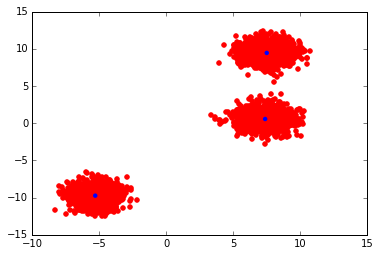

In [17]:
print("RSOM : ",t2-t1)

plt.scatter(DATA[:,0], DATA[:,1], color='red')
plt.scatter(W[:,0],W[:,1],color='blue',s=20,edgecolor='none')